In [42]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import robot_visualize as rbvis



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
ckpt_path = "/mnt/data1/act/train_act_scara_pick_onefruit_block/fruit_block_aug2/"
stats_path = ckpt_path + "dataset_stats.pkl"
with open(stats_path, "rb") as f:
    stats = pickle.load(f)

post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]

def post_process_all_actions(all_actions):
    # post process all actions
    joint_states_traj = []
    actual_actions = []
    for i, raw_action in enumerate(all_actions):
        actual_action = post_process_action(raw_action)
        actual_actions.append(actual_action)
    actual_actions = np.asarray(actual_actions)
    # print(actual_actions)
    return actual_actions

In [49]:
urdf_path = "../hitbot_model.urdf"
print("URDF Path: ", urdf_path)
(ok, tree)  = kdl_parser_py.urdf.treeFromFile(urdf_path)
print("kdl_parse urdf ok?: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
wrist_proj_mat = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 
                            0.0, 0.0, 429.129150390625, 242.32749938964844, 
                            0.0, 0.0, 0.0, 1.0, 0.0]]).reshape([3, 4])


URDF Path:  ../hitbot_model.urdf
kdl_parse urdf ok?:  True


In [43]:
debug_folder = "/mnt/data1/act/temperal_agg_debug/"

act_vis_img = np.ones([480, 640, 3], dtype=np.uint8) * 255


(100, 5)

In [127]:
i = 120
traj_img = act_vis_img.copy()
# for i in range(155, 157):
action_file = debug_folder + "actions_%05i.csv" % i
actions_raw = np.loadtxt(action_file, delimiter=",")
vis_actions = post_process_all_actions(actions_raw)
traj_img = rbvis.paint_action_in_image_cv(traj_img, vis_actions, wrist_proj_mat, fk_solver, chain)
    # save image
    # cv.imwrite("./temp/" + "action_vis_%05i.png" % i, traj_img)


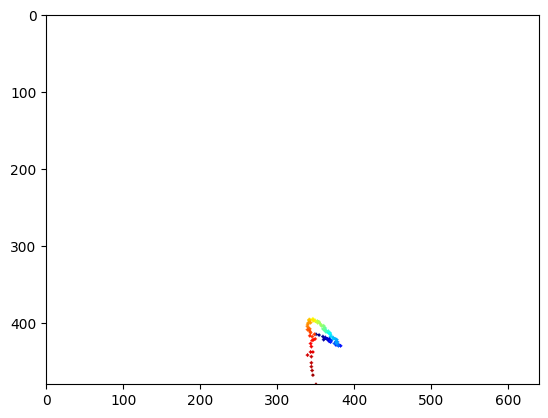

In [128]:
plt.imshow(traj_img)

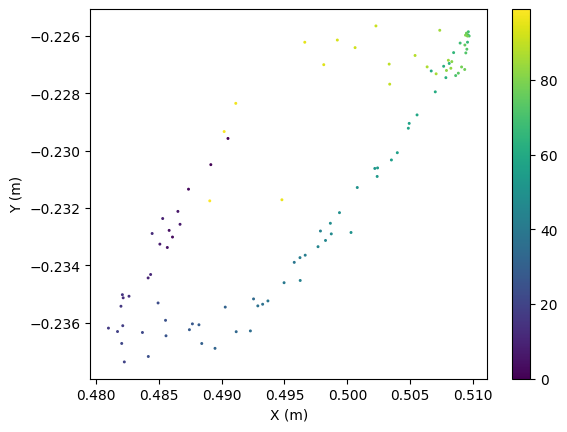

In [126]:
cam_poses, cam_poses_raw, link_poses_list = rbvis.get_camera_poses(vis_actions, fk_solver, chain)

plt.scatter(cam_poses[:, 0], cam_poses[:, 1], c=range(len(cam_poses)), s=5, marker='.')
# plt.ylim([-0.3, -0.2])
# plt.xlim([0.4, 0.6])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

In [199]:
def temporal_agg_fn(op_steps, all_time_actions, all_actions, action_chunking_len):
    all_actions_in_chunk = all_actions[:, :action_chunking_len, :]

    temporal_agg_k = 0.1
    # temporal_agg_k = 1

    # ---------------------- temporal_agg -------------------
    print("--------temporal_agg-------")
    print("all_actions_in_chunk: ", all_actions_in_chunk.shape)
    print("op_steps: ", op_steps)
    print("op_steps+action_chunking_len: ", op_steps+action_chunking_len)
    print("op_steps+all_time_actions: ", all_time_actions.shape)

    all_time_actions[[op_steps], op_steps:op_steps+action_chunking_len] = all_actions_in_chunk
    actions_for_curr_step = all_time_actions[:, op_steps]
    print("actions_for_curr_step: ", actions_for_curr_step.shape)

    actions_populated = np.all(actions_for_curr_step != 0, axis=1)
    # print("actions_populated: ", actions_populated)

    print("actions_for_curr_step: ", actions_for_curr_step.shape)
    actions_for_curr_step = actions_for_curr_step[actions_populated]
    print("actions_for_curr_step: ", actions_for_curr_step.shape)

    exp_weights = np.expand_dims(np.exp(-temporal_agg_k * np.arange(len(actions_for_curr_step))), axis=1)
    # print("exp_weights: ", exp_weights)

    exp_weights = exp_weights / exp_weights.sum()

    # print("exp_weights: ", exp_weights)
    # print("actions_for_curr_step: ", actions_for_curr_step.shape)

    raw_action = np.sum(actions_for_curr_step * exp_weights, axis=0, keepdims=True)

    raw_action = raw_action.squeeze(0)
    # print("raw_action: ", raw_action)
    # ---------------------- temporal_agg -------------------
    return raw_action, all_time_actions

In [200]:
action_chunking_len = 100
max_act_steps = 300
op_steps = 0
action_dim = 5

all_time_actions = np.zeros([max_act_steps, max_act_steps+action_chunking_len, action_dim])

traj_img = act_vis_img.copy()
i = 0

for i in range(120, 220):
    action_file = debug_folder + "actions_%05i.csv" % i
    actions_raw = np.loadtxt(action_file, delimiter=",")
    actions_raw = np.reshape(actions_raw, [1, len(actions_raw), action_dim])

    traj_img = act_vis_img.copy()

    # print("actions_raw :", actions_raw)
    actual_action, all_time_actions = temporal_agg_fn(op_steps, all_time_actions, actions_raw, action_chunking_len)
    op_steps += 1
    if op_steps >= max_act_steps:
        op_steps = 0
    # print("actual_action :", actual_action)

    vis_ori_actions = post_process_all_actions(actions_raw).reshape(-1, action_dim)
    vis_act_actions = post_process_all_actions(actual_action.reshape(-1, action_dim)).reshape(-1, action_dim)

    traj_img = rbvis.paint_action_in_image_cv(traj_img, vis_ori_actions, wrist_proj_mat, fk_solver, chain, vis_act_actions)
    # traj_img = rbvis.paint_action_in_image_cv(traj_img, vis_ori_actions, wrist_proj_mat, fk_solver, chain)

    # save image
    cv.imwrite("./temp/" + "action_vis_%05i.png" % i, cv.cvtColor(traj_img, cv.COLOR_RGB2BGR))


--------temporal_agg-------
all_actions_in_chunk:  (1, 100, 5)
op_steps:  0
op_steps+action_chunking_len:  100
op_steps+all_time_actions:  (300, 400, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (1, 5)
--------temporal_agg-------
all_actions_in_chunk:  (1, 100, 5)
op_steps:  1
op_steps+action_chunking_len:  101
op_steps+all_time_actions:  (300, 400, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (2, 5)
--------temporal_agg-------
all_actions_in_chunk:  (1, 100, 5)
op_steps:  2
op_steps+action_chunking_len:  102
op_steps+all_time_actions:  (300, 400, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (3, 5)
--------temporal_agg-------
all_actions_in_chunk:  (1, 100, 5)
op_steps:  3
op_steps+action_chunking_len:  103
op_steps+all_time_actions:  (300, 400, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (300, 5)
actions_for_curr_step:  (4, 5)


In [187]:
a = np.ones(2)
print("a: ", a.shape)

b = np.ones([2, 5])
print("b: ", b.shape)

a:  (2,)
b:  (2, 5)


In [189]:
b

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [190]:
a

array([1., 1.])

In [188]:
a*b

ValueError: operands could not be broadcast together with shapes (2,) (2,5) 

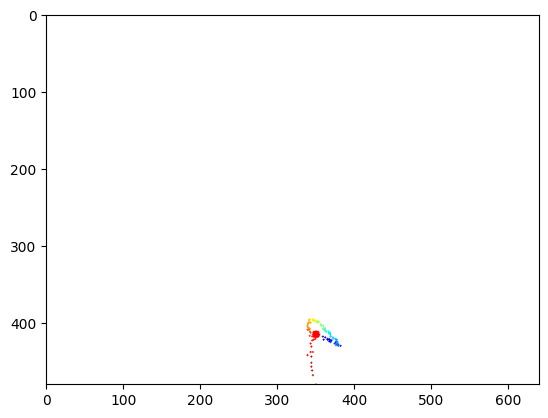

In [177]:
plt.imshow(traj_img)

In [185]:
np.exp(-0.01 * np.arange(10))

array([1.        , 0.99004983, 0.98019867, 0.97044553, 0.96078944,
       0.95122942, 0.94176453, 0.93239382, 0.92311635, 0.91393119])

In [186]:
op_steps = 0
action_chunking_len = 10
max_act_steps = 10
action_dim = 1
all_time_actions = np.zeros([max_act_steps, max_act_steps+action_chunking_len, action_dim])

all_time_actions.shape


(10, 20, 1)

In [187]:
all_actions = np.arange(1, action_chunking_len+1).reshape([1, -1, action_dim])
all_actions.shape

(1, 10, 1)

In [188]:
all_actions

array([[[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10]]])

In [189]:
op_steps = 0
for i in range(max_act_steps):
     actual_action, all_time_actions = temporal_agg_fn(op_steps, all_time_actions, all_actions, action_chunking_len)
     op_steps += 1
     print("actual_action: ", actual_action)


exp_weights:  [1.]
actual_action:  1.0
exp_weights:  [0.50025 0.49975]
actual_action:  1.5002499999791667
exp_weights:  [0.33366672 0.33333322 0.33300006]
actual_action:  2.0006666665555555
exp_weights:  [0.25037512 0.25012487 0.24987488 0.24962513]
actual_action:  2.5012499996458337
exp_weights:  [0.2004002 0.2001999 0.1999998 0.1997999 0.1996002]
actual_action:  3.001999999133334
exp_weights:  [0.16708361 0.16691661 0.16674978 0.16658311 0.16641661 0.16625028]
actual_action:  3.5029166648680574
exp_weights:  [0.14328607 0.14314286 0.14299979 0.14285686 0.14271407 0.14257143
 0.14242893]
actual_action:  4.00399999666667
exp_weights:  [0.12543794 0.12531256 0.12518731 0.12506219 0.12493719 0.12481231
 0.12468756 0.12456294]
actual_action:  4.505249994312509
exp_weights:  [0.11155607 0.11144457 0.11133318 0.11122191 0.11111074 0.11099969
 0.11088874 0.11077791 0.11066719]
actual_action:  5.006666657555573
exp_weights:  [0.1004506 0.1003502 0.1002499 0.1001497 0.1000496 0.0999496 0.09984